<a href="https://colab.research.google.com/github/saniyaverma/Crop-Disease-Prediction-Model-Analysis/blob/main/Tomato_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import json
from zipfile import ZipFile
import shutil
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)  # suppress warnings
import random

In [2]:
SEED = 123

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# Load Kaggle credentials and download dataset
kaggle_credentials = json.load(open("kaggle.json"))
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

!kaggle datasets download -d kaustubhb999/tomatoleaf

# Unzip
with ZipFile("tomatoleaf.zip", 'r') as zip_ref:
    zip_ref.extractall()

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
tomatoleaf.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Paths from the dataset
train_path = "/content/tomato/train"
val_path = "/content/tomato/val"

**Create a unified folder**

In [5]:
# New unified folder
combined_path = "/content/tomato-leaf-disease"
os.makedirs(combined_path, exist_ok=True)

def combine_folders(source_dir, target_dir):
    for cls in os.listdir(source_dir):
        src_cls_path = os.path.join(source_dir, cls)
        dst_cls_path = os.path.join(target_dir, cls)
        os.makedirs(dst_cls_path, exist_ok=True)

        for file_name in os.listdir(src_cls_path):
            src_file = os.path.join(src_cls_path, file_name)
            dst_file = os.path.join(dst_cls_path, file_name)

            # Only copy if file doesn't already exist
            if not os.path.exists(dst_file):
                shutil.copy2(src_file, dst_file)

        print(f"Copied: {cls} from {source_dir} to {target_dir}")

# Combine all splits into one
combine_folders(train_path, combined_path)
combine_folders(val_path, combined_path)

Copied: Tomato___Septoria_leaf_spot from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___healthy from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Target_Spot from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Leaf_Mold from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Tomato_Yellow_Leaf_Curl_Virus from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Spider_mites Two-spotted_spider_mite from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Tomato_mosaic_virus from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Late_blight from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Bacterial_spot from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Early_blight from /content/tomato/train to /content/tomato-leaf-disease
Copied: Tomato___Septoria_leaf_spot from /content/tomato/val to 

**Check for total image count**

In [6]:
def count_images_in_folders(folder_path):
    total_images = 0
    print(f"\nChecking folder: {folder_path}")
    for cls in sorted(os.listdir(folder_path)):
        cls_path = os.path.join(folder_path, cls)
        if os.path.isdir(cls_path):
            count = len(os.listdir(cls_path))
            total_images += count
            print(f"{cls}: {count} images")
    print(f"\nTotal images: {total_images}")

# Run this:
count_images_in_folders("/content/tomato-leaf-disease")


Checking folder: /content/tomato-leaf-disease
Tomato___Bacterial_spot: 1100 images
Tomato___Early_blight: 1100 images
Tomato___Late_blight: 1100 images
Tomato___Leaf_Mold: 1100 images
Tomato___Septoria_leaf_spot: 1100 images
Tomato___Spider_mites Two-spotted_spider_mite: 1100 images
Tomato___Target_Spot: 1100 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1100 images
Tomato___Tomato_mosaic_virus: 1100 images
Tomato___healthy: 1100 images

Total images: 11000


**Check for Corrupt or Unreadable Images**

In [7]:
def check_image_integrity(folder_path):
    broken = []
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        for img_file in os.listdir(cls_path):
            try:
                img_path = os.path.join(cls_path, img_file)
                with Image.open(img_path) as img:
                    img.verify()
            except Exception as e:
                broken.append(img_path)
                print(f"Corrupt: {img_path} — {e}")
    if not broken:
        print("All images verified successfully.")
    else:
        print(f"Found {len(broken)} corrupt images.")

check_image_integrity("/content/tomato-leaf-disease")


All images verified successfully.


**Import data into tensorflow dataset object**

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 8

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    combined_path,
    seed=SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int"
)

class_names = dataset.class_names
NUM_CLASSES = len(class_names)

Found 11000 files belonging to 10 classes.


**Splitting the dataset**

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)
    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=123)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

1100

In [11]:
len(val_ds)

137

In [12]:
len(test_ds)

138

**Preprocessing the Data**

In [13]:
# Resize and Rescale
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

# Data Augmentation
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, training=False):
    ds = ds.map(lambda x, y: (resize_rescale(x), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (augment(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

# Apply preprocessing
train_ds = prepare(train_ds, training=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)


In [14]:
# Load ResNet50 base
base_model = tf.keras.applications.ResNet50(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,641,930 (94.00 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
# Early stopping callback
early_stop = keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

initial_epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=[early_stop]
)

Epoch 1/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 107s 72ms/step - accuracy: 0.1296 - loss: 2.3590 - val_accuracy: 0.1515 - val_loss: 2.2065
Epoch 2/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.1462 - loss: 2.1987 - val_accuracy: 0.1816 - val_loss: 2.1498
Epoch 3/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 85s 69ms/step - accuracy: 0.1702 - loss: 2.1635 - val_accuracy: 0.1670 - val_loss: 2.1435
Epoch 4/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - accuracy: 0.1733 - loss: 2.1482 - val_accuracy: 0.2500 - val_loss: 2.0587
Epoch 5/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 83s 68ms/step - accuracy: 0.1968 - loss: 2.1274 - val_accuracy: 0.2655 - val_loss: 2.0493
Epoch 6/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 133s 61ms/step - accuracy: 0.2050 - loss: 2.1030 - val_accuracy: 0.2427 - val_loss: 2.0314
Epoch 7/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 84s 62ms/step - accuracy: 0.1987 - loss: 2.0872 - val_accuracy: 0.2272 - val_loss: 2.0908
Epoch 8/10
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - accuracy: 0.2114

In [16]:
# Unfreeze the base_model
base_model.trainable = True

# Avoid unfreezing BatchNormalization layers
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Re-compile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 11/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 163s 111ms/step - accuracy: 0.1105 - loss: 2.5655 - val_accuracy: 0.1013 - val_loss: 2.3243
Epoch 12/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 135s 114ms/step - accuracy: 0.1020 - loss: 2.3210 - val_accuracy: 0.1515 - val_loss: 2.2332
Epoch 13/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 127s 108ms/step - accuracy: 0.1442 - loss: 2.2621 - val_accuracy: 0.2993 - val_loss: 1.9325
Epoch 14/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 128s 108ms/step - accuracy: 0.3495 - loss: 1.8151 - val_accuracy: 0.4827 - val_loss: 1.4883
Epoch 15/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 141s 108ms/step - accuracy: 0.4529 - loss: 1.5302 - val_accuracy: 0.5338 - val_loss: 1.3507
Epoch 16/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 135s 115ms/step - accuracy: 0.5010 - loss: 1.3970 - val_accuracy: 0.6077 - val_loss: 1.1549
Epoch 17/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 134s 108ms/step - accuracy: 0.5441 - loss: 1.2820 - val_accuracy: 0.5757 - val_loss: 1.1565
Epoch 18/30
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 139s 119ms/s

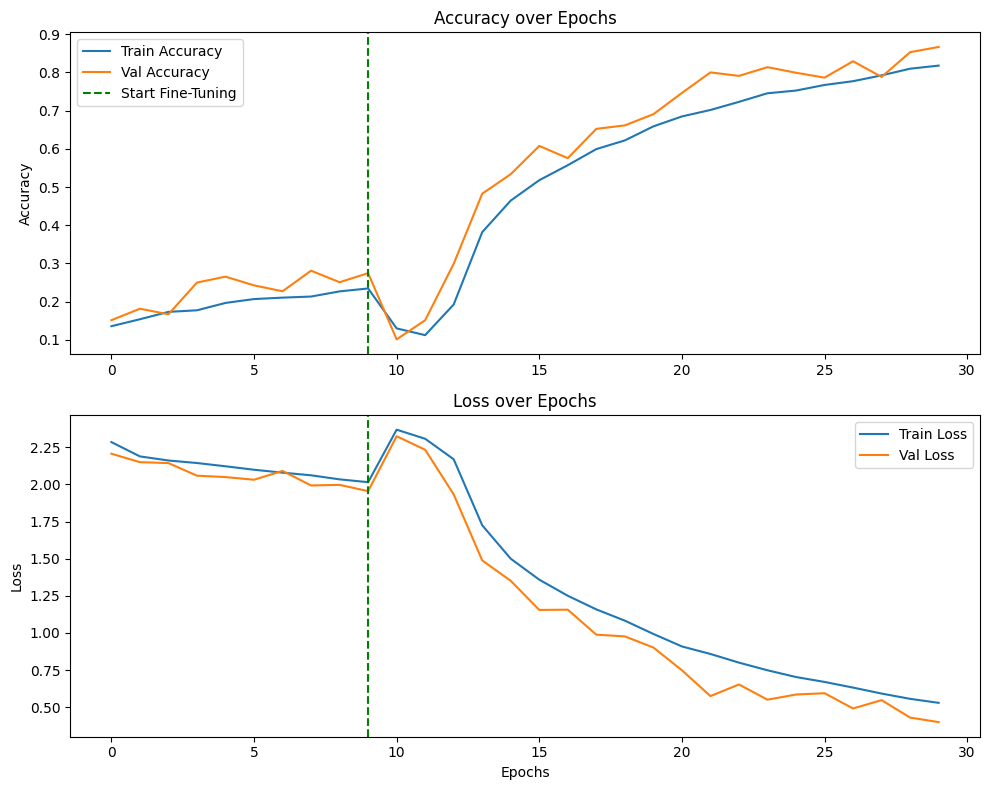

In [17]:
# Combine metrics from both phases
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(10, 8))

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.axvline(x=initial_epochs - 1, color='green', linestyle='--', label='Start Fine-Tuning')
plt.title('Accuracy over Epochs')
plt.legend()
plt.ylabel('Accuracy')

# Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.axvline(x=initial_epochs - 1, color='green', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

first image to print
first image actual label: Tomato___Tomato_mosaic_virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
predicted label Tomato___Tomato_mosaic_virus


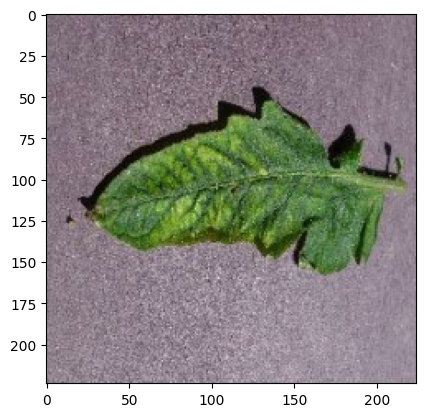

In [21]:
for image_batch,label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy() * 255).astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image to print")
    plt.imshow(first_image)
    print("first image actual label:",class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted label",class_names[np.argmax(batch_prediction[0])])

In [22]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


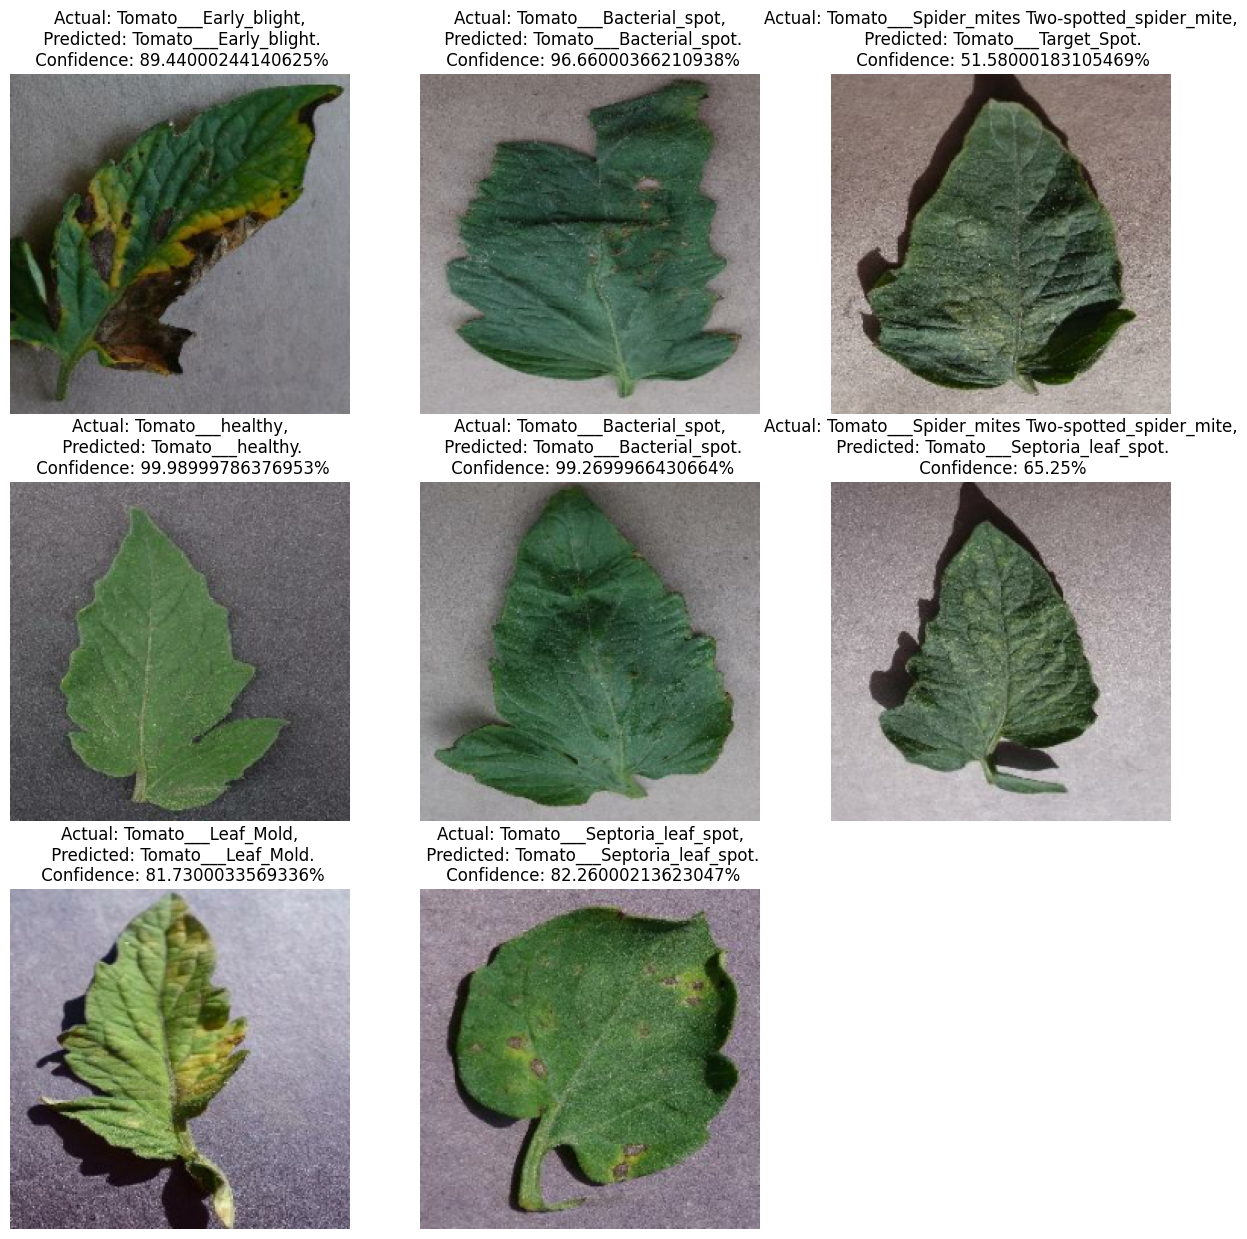

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 3, i + 1)

        plt.imshow((images[i].numpy() * 255).astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [25]:
y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)
    true_classes = labels.numpy()


    y_true.extend(true_classes)
    y_pred.extend(preds_classes)
    y_prob.extend(preds)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

**Accuracy**

In [27]:
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 85.31%


**Precision**

In [28]:
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro', 'micro'
print(f"Precision: {precision * 100:.2f}%")

Precision: 85.93%


**Recall**

In [29]:
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall * 100:.2f}%")

Recall: 85.31%


**F1 Score**

In [30]:
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"f1: {f1 * 100:.2f}%")

f1: 85.23%


**Confusion Matrix**

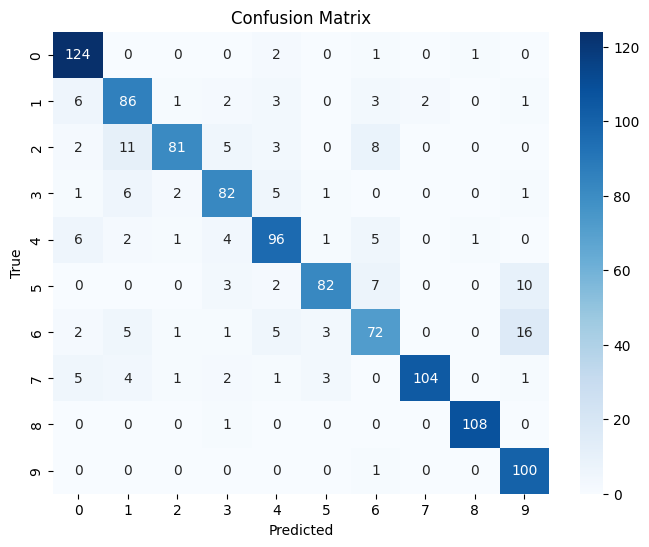

In [31]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**AUROC**

In [32]:
from sklearn.metrics import roc_auc_score

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro') * 100
    print(f"Macro-Averaged ROC-AUC Score: {auc_score:.2f}%")
except Exception as e:
    print("ROC AUC not available:", e)

Macro-Averaged ROC-AUC Score: 99.05%


In [33]:
model.save('tomato-leaf-disease_ResNet50_model.keras')

print("Model saved successfully!")

Model saved successfully!
